In [104]:
%matplotlib inline

In [105]:
import torch
from torchvision import datasets, models, transforms
import numpy as np
import os
import torch.nn as nn
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import matplotlib.pyplot as plt

## 1. Read the model checkpoint

In [106]:
def load_checkpoint(checkpoint_path, DEVICE):
  checkpoint = torch.load(checkpoint_path, map_location=DEVICE)
  return checkpoint

def load_model_fm_checkpoint(checkpoint, primitive_model, DEVICE):
  primitive_model.load_state_dict(checkpoint['model_state_dict'])
  return primitive_model.to(DEVICE)

def getVGGModel():
  vgg16 = models.vgg16_bn(weights=models.vgg.VGG16_BN_Weights.IMAGENET1K_V1)

  # Fix the conv layers parameters
  for conv_param in vgg16.features.parameters():
    conv_param.require_grad = False

  # Replace w/ new classification layers
  classifications = nn.Sequential(
    nn.Flatten(),
    nn.Linear(25088,1024),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5),
    nn.Linear(1024,3)
  )

  vgg16.classifier = classifications

  return vgg16

In [107]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model_dump_dir = "./output_model/best_model.pt"
model = None

try:
    ckpt = load_checkpoint(model_dump_dir, DEVICE)
    model = load_model_fm_checkpoint(ckpt, getVGGModel(), DEVICE)
except FileNotFoundError: 
    print(f"{model_dump_dir} does not exist, please first train the model before performing inference!") 

./output_model/best_model.pt does not exist, please first train the model before performing inference!


## 2. Load in the dataset

In [108]:
def load_test_datasets(test_path):
  img_transform = transforms.Compose([transforms.Resize((244,244)),transforms.ToTensor()])
  try:
    test_dataset = datasets.ImageFolder(test_path, transform=img_transform) 
  except:
    print(f"test_path: {test_path} does not exist!")
  print(f"Test set size: {len(test_dataset)}")
  return test_dataset

In [109]:
# Please specify the path to train, cross_validation, and test images below:
test_path = "/tmp/Dataset_2/Validation/"
test_set = load_test_datasets(test_path)

Test set size: 363


## 3. Perform inference on a random image

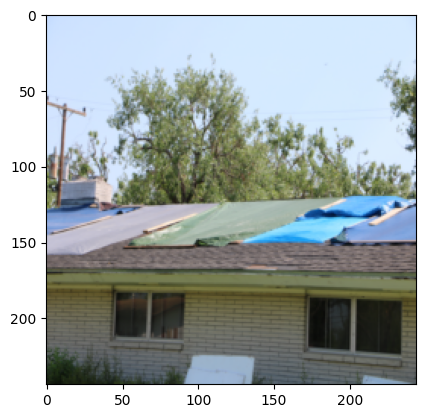

label: 1 for image_idx: tensor([[212]])
prediction result: 1


In [103]:
random_idx = torch.randint(0, len(test_set), size=(1,1))
sample_image, label = val_set[random_idx]
plt.imshow(sample_image.permute(1,2,0))
plt.show()
print(f"label: {label} for image_idx: {random_idx}")

sample = sample_image.unsqueeze(0).to(DEVICE)
prediction = torch.argmax(model(sample))
print(f"prediction result: {prediction}")